# Feature Engineering for Bird Whisperer

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa
from audio_processing import AudioProcessor
import matplotlib.pyplot as plt

np.random.seed(42)

/home/david/miniconda3/envs/bird-whisperer/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First we define some constants and load the metadata.

In [2]:
TRAIN_INPUT_FILE = "../data/cleaned/80_20_cleaned_train.parquet"
TEST_INPUT_FILE = "../data/cleaned/80_20_cleaned_test.parquet"
INPUT_AUDIO_DIR = "../data/raw/audio/xeno_canto"
OUTPUT_METADATA_DIR = '../data/processed/bird-whisperer'
OUTPUT_SPECTROGRAM_DIR = '../data/processed/bird-whisperer/spectograms'
SAMPLE_RATE = 16 * 1000 # 16kHz
SEGMENT_DURATION = 30 # whisper expects 30s segments
TARGET_RECORDINGS_PER_SPECIES = 100

train_df = pd.read_parquet(TRAIN_INPUT_FILE)
test_df = pd.read_parquet(TEST_INPUT_FILE)

ap = AudioProcessor(sample_rate=SAMPLE_RATE, segment_duration=SEGMENT_DURATION, target_db_level=-20, seed=42)

Then we calculate how many augmented samples we need for each species.

In [3]:
species_counts = train_df['en'].value_counts()

augmentation_factors = {}
for species, count in species_counts.items():
    if count > 100:
        max_augment_per_sample = 1
    elif count > 50:
        max_augment_per_sample = 2
    elif count > 25:
        max_augment_per_sample = 5
    else:
        max_augment_per_sample = 10

    needed_augmentations = max(0, TARGET_RECORDINGS_PER_SPECIES - count)
    augmentation_factors[species] = min(
        max(1, needed_augmentations // count), max_augment_per_sample
    )

Here the bulk of the work is done by loading all audio files and creating log mel spectrograms for each of them.

Finally we save the log mel spectrograms to disk.

In [4]:
# Parameters for log mel spectrogram according to the paper: "an 80-channel log-magnitude Mel-spectrogram is computed using 25-millisecond windows with a 10-millisecond stride, resulting in overlapping windows.""
log_mel_params = {
   "n_fft": int(0.025 * SAMPLE_RATE), # 25 milliseconds in samples
   "hop_length": int(0.010 * SAMPLE_RATE), # 10 milliseconds in samples
   "n_mels": 80 # Number of Mel bands
  }

In [5]:
def process_recordings(df, augment, output_spectogram_dir):
  outputs = []
  os.makedirs(output_spectogram_dir, exist_ok=True)

  for index, row in tqdm(df.iterrows(), total=df.shape[0]):
      if index > 100:
          break

      audio_id = row['id']
      species_name = row['en']

      original_audio_file_name = row["file-name"]
      file_extension = original_audio_file_name.split(".")[-1]
      new_audio_file_name = f"{row['id']}.{file_extension}"
      full_audio_file_path = os.path.join(INPUT_AUDIO_DIR, new_audio_file_name)

      if not os.path.exists(full_audio_file_path):
        print(f"Audio file {new_audio_file_name} not found. Skipping.")
        continue

      try:
        # load and process the audio file
        audio_content = ap.process_audio_file_with_denoising(full_audio_file_path)
        spectogram = ap.create_log_mel_spectrogram(audio_content, n_fft=log_mel_params["n_fft"], hop_length=log_mel_params["hop_length"], n_mels=log_mel_params["n_mels"])
        normalized_spectogram = ap.normalize_spectrogram(spectogram)

        # save the spectogram
        output_file_name = f"{audio_id}.pt"
        output_file_path = os.path.join(output_spectogram_dir, output_file_name)
        ap.save_log_mel_spectrogram(normalized_spectogram, output_file_path, type='torch')

        outputs.append({'id': audio_id, 'species': species_name, 'spectogram_file': output_file_name, 'augmented': False})

        if not augment:
          continue

        # augment the spectogram if needed
        for i in range(augmentation_factors.get(species_name, 0)):
          audio_content_aug = ap.add_augmentations(audio_content)
          spectogram = ap.create_log_mel_spectrogram(audio_content_aug, n_fft=log_mel_params["n_fft"], hop_length=log_mel_params["hop_length"], n_mels=log_mel_params["n_mels"])
          spectogram_aug = ap.apply_spectrogram_augmentation(
                spectogram,
                time_mask_lower=300, time_mask_upper=500,
                freq_mask_lower=12, freq_mask_upper=15
            )
          normalized_spectogram_aug = ap.normalize_spectrogram(spectogram_aug)

          # save the augmented spectogram
          output_file_name = f"{audio_id}_aug_{i}.pt"
          output_file_path = os.path.join(output_spectogram_dir, output_file_name)
          ap.save_log_mel_spectrogram(normalized_spectogram_aug, output_file_path, type='torch')

          outputs.append({'id': audio_id, 'species': species_name, 'spectogram_file': output_file_name, 'augmented': True})
      except Exception as e:
        print(f"Error loading audio file {new_audio_file_name}: {e}. Skipping.")
        continue

  return outputs

In [6]:
train_output_dir = os.path.join(OUTPUT_SPECTROGRAM_DIR, 'train')
test_output_dir = os.path.join(OUTPUT_SPECTROGRAM_DIR, 'test')

train_outputs = process_recordings(train_df, augment=True, output_spectogram_dir=train_output_dir)
test_outputs = process_recordings(test_df, augment=False, output_spectogram_dir=test_output_dir)

  0%|          | 34/16538 [00:05<53:53,  5.10it/s]  Note: Illegal Audio-MPEG-Header 0x0000414c at offset 191360.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
  1%|          | 83/16538 [00:13<53:39,  5.11it/s]Note: Illegal Audio-MPEG-Header 0x756c6120 at offset 78400.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
  1%|          | 101/16538 [00:16<44:04,  6.22it/s]


Save the outputs to a file.

In [7]:
train_output_df = pd.DataFrame(train_outputs)
test_output_df = pd.DataFrame(test_outputs)

train_metadata_output_file = os.path.join(OUTPUT_METADATA_DIR, 'train.parquet')
test_metadata_output_file = os.path.join(OUTPUT_METADATA_DIR, 'test.parquet')

train_output_df.to_parquet(train_metadata_output_file)
test_output_df.to_parquet(test_metadata_output_file)

Display a few samples of augmented and not augmented log mel spectrograms.

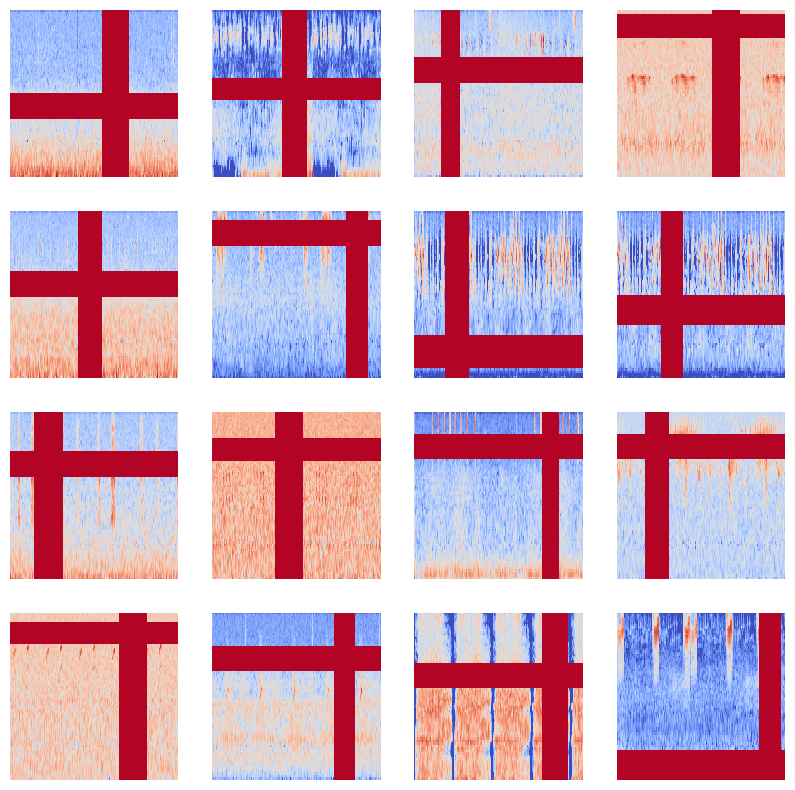

In [9]:
# display a 4x4 grid of augmented spectograms
augmented_outputs = [output for output in train_outputs if output["augmented"]]

plt.figure(figsize=(10, 10))
for i in range(16):
    spectogram_path = os.path.join(train_output_dir, augmented_outputs[i]["spectogram_file"])
    spec = ap.load_log_mel_spectrogram(spectogram_path, type='torch')
    plt.subplot(4, 4, i + 1)
    librosa.display.specshow(
      spec,
      sr=SAMPLE_RATE,
      hop_length=log_mel_params["hop_length"],
      x_axis="frames",
      y_axis="mel",
  )
    plt.axis("off")

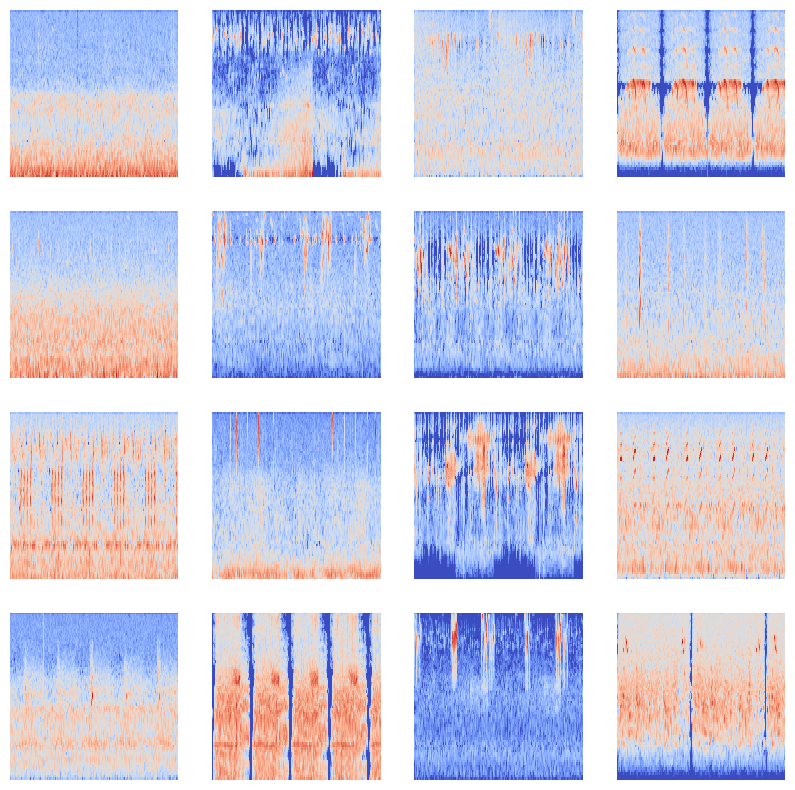

In [10]:
# display a 4x4 grid of non-augmented spectograms
non_augmented_outputs = [output for output in train_outputs if not output["augmented"]]

plt.figure(figsize=(10, 10))
for i in range(16):
    spectogram_path = os.path.join(train_output_dir, non_augmented_outputs[i]["spectogram_file"])
    spec = ap.load_log_mel_spectrogram(spectogram_path, type='torch')
    plt.subplot(4, 4, i + 1)
    librosa.display.specshow(
      spec,
      sr=SAMPLE_RATE,
      hop_length=log_mel_params["hop_length"],
      x_axis="frames",
      y_axis="mel",
  )
    plt.axis("off")